In [1]:
from catboost import CatBoostClassifier, CatBoostRegressor
from scipy import stats
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, roc_auc_score, f1_score, recall_score, precision_recall_curve, auc, average_precision_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from fancyimpute import IterativeImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import GridSearchCV
import xlsxwriter
from random import randint
random_state = 7656
from preprocessing import stds, stats, cv_preprocessing
from load_data import load_data
import os
from scipy.stats import mode

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
#from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Using TensorFlow backend.
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nogag\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users

## Multi Cat-Boost

In [2]:
pcls = ["q6.1_INTRU", "q6.2_DREAM", "q6.3_FLASH", "q6.4_UPSET",
               "q6.5_PHYS", "q6.6_AVTHT", "q6.7_AVSIT", "q6.8_AMNES", "q6.9_DISINT",
               "q6.10_DTACH", "q6.11_NUMB", "q6.12_FUTRE", "q6.13_SLEEP",
               "q6.14_ANGER", "q6.15_CONC", "q6.16_HYPER", "q6.17_STRTL"]
phqs = [f"T1q5.{i}" for i in range(1, 10)]
phqs2 = [f"T1q5.{i}_" for i in range(1, 10)]


average_precision_score = 0.4250697075376254
pr_auc = 0.3948973102267876


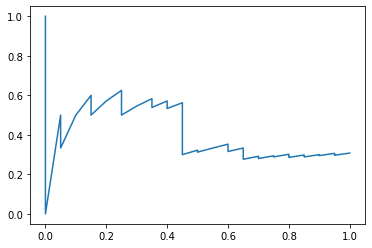

holdout i = , roc_auc = 0.7208333333333333


NameError: name 'printd' is not defined

In [8]:
df_preprocessed, features, target_feature = load_data()
df_preprocessed[phqs2] = 0
df_preprocessed[phqs2] = df_preprocessed[phqs] + 1
df_preprocessed['blop1'] = mode(df_preprocessed[phqs2+pcls], axis=1)[0]
df_preprocessed['blop2'] = mode(df_preprocessed[pcls], axis=1)[0]
df_preprocessed['blop3'] = mode(df_preprocessed[phqs2], axis=1)[0]
features.extend(['blop1', 'blop2', 'blop3'])
features2 = [i for i in features if i not in phqs+pcls]
#df_preprocessed = df_preprocessed[~df_preprocessed['phq3'].isna()]
secondary_targets2 = { i:2 for i in target_feature}
#     'PCL_Strict3':0,
#      'q6.1_INTRU_target':2,
#  'q6.2_DREAM_target':2,
#  'q6.3_FLASH_target':2,
#  'q6.4_UPSET_target':2,
#  'q6.5_PHYS_target':2,
#     'target_intrusion':10
# }

secondary_targets = {
    
         'q6.1_INTRU_target':1,
 'q6.2_DREAM_target':1,
  'q6.3_FLASH_target':1,
    'q6.4_UPSET_target':2,
  'q6.5_PHYS_target':1,
}

for j in range(1):
    X, X_out, Y, y_out = train_test_split(df_preprocessed[features + list(secondary_targets.keys())], df_preprocessed['target_binary_intrusion'],\
                                          test_size=0.15, random_state=random_state,\
                                          stratify=df_preprocessed['target_binary_intrusion'])


    cv = StratifiedKFold(5)

    for train, test in cv.split(X, Y):
        
        x_train2, y_train = X.iloc[train], Y.iloc[train]
        x_test2, y_test = X.iloc[test], Y.iloc[test]
        
        x_train = x_train2[features]
        x_test = x_test2[features]
        
        x_train, x_test = cv_preprocessing(x_train, x_test)
        x_train = x_train[features2]
        x_test = x_test[features2]
        train_preds = np.zeros_like(y_train)
        test_preds = np.zeros_like(y_test)

        for k in secondary_targets.keys():
            lim2 = x_train2[k].apply(lambda x: int(x > 2))
            lim1 = x_train2[k].apply(lambda x: int(x > 1))



            model2 = LogisticRegression(verbose=0, class_weight=[10, 1], max_iter=250)
            model2.fit(x_train,lim2)
            
            train_hat = model2.predict_proba(x_train)[:,1]
            test_hat = model2.predict_proba(x_test)[:,1]

            train_preds = np.vstack([train_preds, train_hat])
            test_preds = np.vstack([test_preds, test_hat])

            
            model1 = LogisticRegression(verbose=0, class_weight=[5, 1], max_iter=250)
            model1.fit(x_train,lim1)
            
            train_hat = model1.predict_proba(x_train)[:,1]
            test_hat = model1.predict_proba(x_test)[:,1]

            train_preds = np.vstack([train_preds, train_hat])
            test_preds = np.vstack([test_preds, test_hat])

             
            
        x_train = np.hstack([train_preds.T, x_train])
        x_test = np.hstack([test_preds.T, x_test])
        
        
        
        model = CatBoostClassifier(verbose=0,  class_weights=[10, 1])
        model.fit(x_train,y_train)

        #y_pred = model.predict(x_test)
        #y_pred = np.vstack([preds, model.predict_proba(x_test)[:,1]]).min(axis=0)
        y_pred = model.predict_proba(x_test)[:,1]


        #print(f1_score(y_test.astype(int), y_pred))
        precision, recall, _ = precision_recall_curve(y_test.astype(int), y_pred)
        avs = average_precision_score(y_test.astype(int), y_pred)
        print(f"average_precision_score = {avs}")

        auc_score = auc(recall, precision)
        print(f"pr_auc = {auc_score}")
        plt.plot(recall, precision)
        plt.show()
        print(f"holdout i = , roc_auc = {roc_auc_score(y_test.astype(int), y_pred)}")
        printd('f')

In [27]:
model.get_feature_importance().shape

(104,)

In [20]:
features

['highschool_diploma',
 'ADHD',
 'T1Acc1t',
 'T1Acc1n',
 'T1bias',
 'phq1',
 'trait1',
 'state1',
 'PCL1',
 'intrusion_PCL_T1',
 'T1mean1t',
 'T1mean1n',
 'PCL_Strict1',
 'ABV',
 'dyslexia',
 'trauma_history6_1',
 'terror_p1',
 'terror_i1',
 'mva_p1',
 'mva_i1',
 'violent1',
 'sexual1',
 'q6.1_INTRU',
 'q6.2_DREAM',
 'q6.3_FLASH',
 'q6.4_UPSET',
 'q6.5_PHYS',
 'q6.6_AVTHT',
 'q6.7_AVSIT',
 'q6.8_AMNES',
 'q6.9_DISINT',
 'q6.10_DTACH',
 'q6.11_NUMB',
 'q6.12_FUTRE',
 'q6.13_SLEEP',
 'q6.14_ANGER',
 'q6.15_CONC',
 'q6.16_HYPER',
 'q6.17_STRTL',
 'intrusion_score',
 'intrusion_mean',
 'intrusion_std',
 'binary_intrusion',
 'tred_score',
 'tred_mean',
 'tred_std',
 'binary_tred',
 'avoidance_score',
 'avoidance_mean',
 'avoidance_std',
 'binary_avoidance',
 'hyper_score',
 'hyper_mean',
 'hyper_std',
 'binary_hyper',
 'T1q5.1',
 'T1q5.2',
 'T1q5.3',
 'T1q5.4',
 'T1q5.5',
 'T1q5.6',
 'T1q5.7',
 'T1q5.8',
 'T1q5.9',
 'phq_physical_score',
 'binary_phq_physical',
 'phq_feels_score',
 'binary_

In [5]:
df_preprocessed.columns.count()

AttributeError: 'Index' object has no attribute 'count'

In [1]:
df_preprocessed[(df_preprocessed['intrusion_PCL_T1'] == 1) &(df_preprocessed['target_binary_intrusion']==0)]

NameError: name 'df_preprocessed' is not defined

In [15]:
y_test.iloc[y_pred.argmax()]#[70:100]

0.0

In [90]:
np.hstack([train_preds, x_train]).shape

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 9 and the array at index 1 has size 367

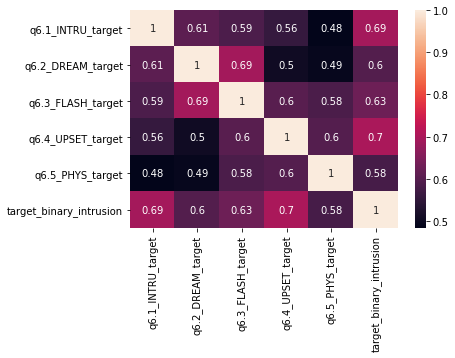

In [9]:
import seaborn as sn
import matplotlib.pyplot as plt
corrMatrix = df_preprocessed[[i for i in secondary_targets.keys()]+['target_binary_intrusion']].corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
x_test2[(model.predict(x_test) == 0) & (y_test.astype(int) == 1 )][features]

In [16]:
x_test2[(model.predict(x_test) == 1) & (y_test.astype(int) == 0 )][features]

,highschool_diploma,ADHD,T1Acc1t,T1Acc1n,T1bias,phq1,trait1,state1,PCL1,intrusion_PCL_T1,...,phq_feels_score,binary_phq_feels,phq_an_score,binary_phq_an,phq_func_score,binary_phq_func,phq_score,phq_mean,phq_std,binary_phq
603,0.0,0.0,0.9737,1.0000,19.34,10.0,37.0,26.0,36.0,0.0,...,2.0,0.0,3.0,1.0,2.0,1.0,10.0,1.111111,1.054093,1.0
115,0.0,1.0,0.9605,0.9868,-0.86,18.0,35.0,60.0,53.0,1.0,...,6.0,1.0,5.0,1.0,4.0,1.0,18.0,2.000000,1.118034,1.0
406,1.0,0.0,0.9868,0.9737,-15.42,3.0,24.0,20.0,17.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.333333,0.500000,0.0
69,1.0,0.0,1.0000,1.0000,-14.07,9.0,41.0,42.0,28.0,0.0,...,1.0,0.0,3.0,1.0,2.0,0.0,9.0,1.000000,0.707107,0.0
682,1.0,0.0,0.9605,1.0000,-28.75,3.0,35.0,36.0,24.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.333333,0.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,1.0,0.0,0.9474,0.9868,15.32,5.0,24.0,24.0,20.0,0.0,...,0.0,0.0,4.0,1.0,3.0,1.0,5.0,0.555556,1.013794,0.0
122,1.0,1.0,0.9868,0.9868,-21.85,11.0,40.0,36.0,36.0,1.0,...,3.0,1.0,3.0,1.0,3.0,1.0,11.0,1.222222,0.666667,1.0
484,0.0,1.0,1.0000,0.9868,-2.63,3.0,33.0,26.0,27.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.333333,0.500000,0.0
582,0.0,0.0,0.9868,0.9868,-19.20,7.0,44.0,45.0,22.0,0.0,...,4.0,1.0,2.0,0.0,1.0,0.0,7.0,0.777778,0.971825,0.0


In [51]:
x_test2[(model.predict(x_test) != y_test.astype(int))].shape

(27, 39)

In [52]:
x_test2[(model.predict(x_test) != y_test.astype(int))].shape

(27, 39)

In [53]:
precision_score(y_test.astype(int), y_pred)

0.37037037037037035

In [54]:
y_test.astype(int).sum()

20

In [55]:
y_pred.sum()

27.0